In [666]:
import torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets
import torch.optim as optim
from torchvision.transforms import transforms
from torchvision.utils import save_image

import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
from DataSet import WaterTemperatureDataSet
import datetime

# Part I: 

Aggregating the data

In [667]:
root_dir = "Data/"
full_col_dir = ["Date", "Temp", "Min", "Max", "Origine", "Site"]
partial_col_dir = ["Date", "Temp", "Origine", "Site"]


Choisy = pd.read_csv(root_dir + "Choisy-le-roi.csv", sep=";", decimal=',') # 1680
Neuilly = pd.read_csv(root_dir + "Neuilly.csv", sep=';', decimal=",") # 1565
Bougival = pd.read_csv(root_dir + "Bougival.csv", sep=";", decimal=",") # 1453
Joinville_EDP = pd.read_csv(root_dir + "Joinville_EDP.txt", sep=",", decimal=".", names=partial_col_dir) # 1565
Orly_EDP = pd.read_csv(root_dir + "Orly_EDP.txt", sep=",", decimal=".", names=full_col_dir) # 1680

St_Maure = pd.read_csv(root_dir + "Historique-St-Maur.csv", sep=";", decimal=",") # This DataFrame will be discarded

buffer = [Bougival, Neuilly, Choisy, Joinville_EDP, Orly_EDP]
safran = [1453, 1565, 1680, 1565, 1680]
station_iter = iter(buffer)
i = 0

name = ["Bougival", "Neuilly", "Choisy", "Joinville_EDP", "Orly_EDP"]
format = {"Bougival": "%d/%m/%Y", "Neuilly": "%d/%m/%Y", "Choisy": "%d/%m/%Y", "Joinville_EDP": "%d/%m/%Y", "Orly_EDP": "%d/%m/%Y"}

In [668]:
table = next(station_iter)
print(name[i])
i += 1 
table

Bougival


,Date,Temp,Min,Max,Origine,Site
0,09/01/1990,6.50,6.30,6.70,2,5
1,10/01/1990,6.30,6.30,6.50,2,5
2,11/01/1990,6.50,6.40,6.70,2,5
3,12/01/1990,6.70,6.60,6.70,2,5
4,13/01/1990,6.80,6.70,6.90,2,5
...,...,...,...,...,...,...
10770,28/08/2022,24.13,23.91,24.36,1,5
10771,29/08/2022,23.97,23.76,24.18,1,5
10772,30/08/2022,23.68,23.48,23.96,1,5
10773,31/08/2022,23.62,23.44,23.77,1,5


In [669]:
air_min = pd.read_csv(root_dir + "TMINJ.txt", sep="\s+")
air_max = pd.read_csv(root_dir + "TMAXJ.txt", sep="\s+")
air_avg = pd.read_csv(root_dir + "TMPH.txt", sep="\s+")

solar = pd.read_csv(root_dir + "SWDH.txt", sep="\s+")

C:\Users\guill\AppData\Local\Temp\ipykernel_2676\3568908246.py:5: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  solar = pd.read_csv(root_dir + "SWDH.txt", sep="\s+")


In [670]:
air_max["I_day"] = pd.to_datetime(air_max["I_day"] - 1, origin='08/01/1970', unit='d')
air_min["I_day"] = pd.to_datetime(air_min["I_day"] - 1, origin='08/01/1970', unit='d')
air_avg["I_Jour"] = pd.to_datetime(air_avg["I_Jour"] - 1, origin='08/01/1970', unit='d')
solar["I_Jour"] = pd.to_datetime(solar["I_Jour"] - 1, origin='08/01/1970', unit='d')

# ensoleillement nombre d'heure au dessus de 140 Wats

In [671]:
cols1 = air_avg.columns
cols2 = solar.columns
avg_temp = air_avg.groupby("I_Jour")[cols1].mean(numeric_only=True)
solar_avg = solar.groupby("I_Jour")[cols2].mean(numeric_only=True)

In [672]:
solar_seal = pd.read_csv(root_dir + "Solar_Above_Threshold.csv", sep=",")
solar_seal["I_Jour"] = pd.to_datetime(solar_seal["I_Jour"])
solar_seal = solar_seal.set_index("I_Jour")

In [673]:
air = pd.merge(air_min, air_max, on="I_day", suffixes=["_min", "_max"])
air = pd.merge(air, avg_temp, right_index=True, left_on="I_day")
air = pd.merge(air, solar_avg, right_index=True, left_on="I_day", suffixes=["", "_solar_avg"])

In [674]:
air = pd.merge(air, solar_seal, left_on="I_day", right_index=True, suffixes=["", "_above_thr"])

In [675]:
air

,I_day,385_min,716_min,718_min,720_min,725_min,753_min,757_min,821_min,826_min,...,1805_above_thr,1928_above_thr,2051_above_thr,2060_above_thr,2301_above_thr,2569_above_thr,3073_above_thr,3084_above_thr,3580_above_thr,4652_above_thr
0,1970-08-01,288.99,288.00,288.01,287.24,286.99,289.88,289.78,288.81,288.68,...,12,12,12,12,12,12,12,11,12,12
1,1970-08-02,288.82,292.10,292.03,291.84,289.59,287.49,287.46,288.40,286.51,...,13,13,13,13,13,13,13,13,13,12
2,1970-08-03,290.06,290.92,290.85,288.97,288.95,289.26,289.34,289.30,288.80,...,13,13,13,13,13,13,13,13,13,12
3,1970-08-04,291.25,292.20,292.15,291.68,291.33,291.79,291.70,290.85,290.15,...,12,12,11,12,12,12,12,12,12,12
4,1970-08-05,291.16,292.12,292.08,292.82,292.15,291.05,291.03,290.31,289.95,...,11,11,11,11,11,12,11,12,13,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18988,2022-07-27,286.79,288.85,288.82,289.42,288.82,288.15,288.02,287.19,286.55,...,12,12,12,12,13,12,12,13,12,13
18989,2022-07-28,288.33,290.26,290.22,286.00,288.10,287.10,287.14,287.38,286.04,...,10,10,10,12,12,12,13,13,12,13
18990,2022-07-29,287.77,290.43,290.43,287.40,288.89,286.58,286.59,289.16,289.38,...,11,10,10,10,11,11,13,11,12,12
18991,2022-07-30,289.88,292.34,292.27,290.05,290.54,289.08,289.07,290.02,290.22,...,12,13,12,13,12,12,12,12,12,12


In [676]:
def perform_data_augmentation(station, water_attribute="Temp", water_min="Min", water_max="Max"): 
    NATURAL = int(0)
    AUGMENTED = int(1)

    station["year"] = pd.DatetimeIndex(station["Date"]).year
    years = station["year"].unique()
    columns = station.columns

    augmented = pd.DataFrame(columns=columns)

    for year in years: 
        index = pd.date_range('01-01-' + str(year), '12-31-' + str(year))
        segment = station.loc[station["year"] == year, columns]
        segment["DataType"] = NATURAL

        first_date = segment["Date"].min()
        last_date = segment["Date"].max()   
        n_points = len(segment["year"]) 
     
        segment = segment.set_index("Date")
        segment = segment.reindex(index, fill_value= -1)

        segment["DataType"] = NATURAL
        segment.loc[segment[water_attribute] == -1, "DataType"] = AUGMENTED
        segment.loc[segment[water_attribute] == -1, [water_attribute, water_max, water_min]] = float('nan')

        if check_validity(segment, n_points, first_date, last_date):
            segment = augment(segment, first_date, last_date, water_attribute=water_attribute, water_min=water_min, water_max=water_max)
            augmented = pd.concat([augmented, segment.rename_axis('Date').reset_index()])

    return augmented

def check_validity(segment, n_points, first_date, last_date):
    date_check = (last_date.month != 12 or last_date.day < 28) or (first_date.month != 1 or first_date.day > 10)

    counter = segment.loc[(segment.index < last_date) & (segment.index > first_date), "DataType"].diff().ne(0).cumsum()
    hole_check = (counter.max() > 10)
    len_check = (len(segment) == 365)
    
    if date_check or hole_check:
        return False
    else: 
        return True

def augment(segment, first_date, last_date, water_attribute="Temp", water_min="Min", water_max="Max"):
    attributes = [water_max, water_min, water_attribute]

    for attribute in attributes: 
        below = segment[[attribute, "DataType"]].fillna(method='ffill')
        above = segment[[attribute, "DataType"]].fillna(method='bfill')

        below = below.loc[below["DataType"] == 1, [attribute]]
        above = above.loc[above["DataType"] == 1, [attribute]]

        mean = pd.merge(below, above, left_index=True, right_index=True).mean(axis=1, numeric_only=True, skipna=True)

        segment.loc[segment["DataType"] == 1, attribute] = mean

    if (len(segment) == 366): 
        year = last_date.year
        index = datetime.date(year=year, day=29, month=2)
        segment.drop(index=index, inplace=True)

    return segment


In [677]:
stations = []

for i, station in enumerate(buffer): 
    station["Date"] = pd.to_datetime(station["Date"].str.replace(" 00:00:00", ""), format="%d/%m/%Y")
    station = perform_data_augmentation(station)
    stations.append(station)

In [678]:
stations[3]

,Date,Temp,Origine,Site,year,DataType,Max,Min
0,2002-01-01,3.30,12,12,2002,0.0,NaN,NaN
1,2002-01-02,3.43,12,12,2002,0.0,NaN,NaN
2,2002-01-03,2.67,12,12,2002,0.0,NaN,NaN
3,2002-01-04,1.52,12,12,2002,0.0,NaN,NaN
4,2002-01-05,0.61,12,12,2002,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...
360,2019-12-27,8.52,12,12,2019,0.0,NaN,NaN
361,2019-12-28,8.50,12,12,2019,0.0,NaN,NaN
362,2019-12-29,8.00,12,12,2019,0.0,NaN,NaN
363,2019-12-30,7.39,12,12,2019,0.0,NaN,NaN


In [679]:
air = air.set_index("I_day")

In [680]:
database = []

for i, station in enumerate(stations): 
    cols = [str(safran[i]), str(safran[i]) + "_min", str(safran[i]) + "_max", str(safran[i]) + "_above_thr", str(safran[i]) + "_solar_avg"]
    append = pd.merge(station, air[cols], left_on="Date", right_index=True).rename(columns=
    {cols[0]:"Air_Avg", cols[1]:"Air_Min", cols[2]:"Air_Max", cols[3]: "Solar_Above_Thr", cols[4]:"Solr_Avg"})
    append["location"] = name[i]
    database.append(append)

In [681]:
main = pd.concat(database)
main.head(-2)

,Date,Temp,Min,Max,Origine,Site,year,DataType,Air_Avg,Air_Min,Air_Max,Solar_Above_Thr,Solr_Avg,location
0,1991-01-01,7.0,6.9,7.2,2,5,1991,0.0,278.858750,276.71,282.89,5,55.559167,Bougival
1,1991-01-02,7.4,7.1,7.8,2,5,1991,0.0,283.542917,283.21,284.79,0,8.470833,Bougival
2,1991-01-03,8.1,7.8,8.4,2,5,1991,0.0,283.259583,280.05,283.77,0,8.675000,Bougival
3,1991-01-04,8.2,7.9,8.4,2,5,1991,0.0,279.304167,275.25,280.26,5,49.350833,Bougival
4,1991-01-05,7.8,7.7,7.9,2,5,1991,0.0,278.867083,277.89,281.05,0,15.035417,Bougival
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
358,2019-12-25,9.4,9.1,9.5,12,26,2019,0.0,281.467917,276.65,282.86,1,30.291250,Orly_EDP
359,2019-12-26,9.2,9.1,9.3,12,26,2019,0.0,280.019583,277.77,283.34,3,38.000000,Orly_EDP
360,2019-12-27,9.3,9.2,9.3,12,26,2019,0.0,281.899583,280.86,282.10,0,10.979167,Orly_EDP
361,2019-12-28,9.1,8.8,9.3,12,26,2019,0.0,279.831667,273.05,281.55,0,12.182500,Orly_EDP


In [682]:
main = main.rename(columns={"Temp": "Water_Avg", "Min": "Water_Min", "Max":"Water_Max"}).drop(columns=["Origine", "Site"])

In [683]:
St_Maure = St_Maure.rename(columns={"Eau_Moy": "Water_Avg", "Eau_Min": "Water_Min", "Eau_Max":"Water_Max", "Air_Moy":"Air_Avg"})
St_Maure["Date"] = pd.to_datetime(St_Maure["Date"], format="%d/%m/%Y")
St_Maure["location"] = "St_Maure_Hist"
St_Maure["DataType"] = 0

St_Maure["Air_Avg"] = St_Maure["Air_Avg"] 
St_Maure["Air_Min"] = St_Maure["Air_Min"] 
St_Maure["Air_Max"] = St_Maure["Air_Max"] 
St_Maure["year"] = pd.DatetimeIndex(St_Maure["Date"]).year

St_Maure = perform_data_augmentation(St_Maure, water_attribute="Water_Avg", water_min="Water_Min", water_max="Water_Max")

St_Maure.head()

,Date,Water_Avg,Water_Min,Water_Max,Air_Avg,Air_Min,Air_Max,location,DataType,year
0,1878-01-01,5.31,5.20,5.43,2.55,-1.3,6.4,St_Maure_Hist,0,1878
1,1878-01-02,5.29,5.25,5.33,-0.50,-2.0,1.0,St_Maure_Hist,0,1878
2,1878-01-03,5.09,5.07,5.11,1.10,-1.5,3.7,St_Maure_Hist,0,1878
3,1878-01-04,5.31,5.25,5.37,3.25,0.9,5.6,St_Maure_Hist,0,1878
4,1878-01-05,3.90,3.84,3.96,1.00,-1.0,3.0,St_Maure_Hist,0,1878


In [684]:
#main = pd.concat([main, St_Maure]) Don't add historical data since they don't have solar data
main

,Date,Water_Avg,Water_Min,Water_Max,year,DataType,Air_Avg,Air_Min,Air_Max,Solar_Above_Thr,Solr_Avg,location
0,1991-01-01,7.0,6.9,7.2,1991,0.0,278.858750,276.71,282.89,5,55.559167,Bougival
1,1991-01-02,7.4,7.1,7.8,1991,0.0,283.542917,283.21,284.79,0,8.470833,Bougival
2,1991-01-03,8.1,7.8,8.4,1991,0.0,283.259583,280.05,283.77,0,8.675000,Bougival
3,1991-01-04,8.2,7.9,8.4,1991,0.0,279.304167,275.25,280.26,5,49.350833,Bougival
4,1991-01-05,7.8,7.7,7.9,1991,0.0,278.867083,277.89,281.05,0,15.035417,Bougival
...,...,...,...,...,...,...,...,...,...,...,...,...
360,2019-12-27,9.3,9.2,9.3,2019,0.0,281.899583,280.86,282.10,0,10.979167,Orly_EDP
361,2019-12-28,9.1,8.8,9.3,2019,0.0,279.831667,273.05,281.55,0,12.182500,Orly_EDP
362,2019-12-29,8.6,8.4,8.8,2019,0.0,275.485000,272.78,277.83,5,51.456250,Orly_EDP
363,2019-12-30,8.1,7.7,8.4,2019,0.0,275.403333,272.20,278.89,6,69.270000,Orly_EDP


# Part II

Creating the series to be fed to the Neural Network

**1) Adding seasons** 

In [685]:
def season_of_date(date):
    year = str(date.year)
    seasons = {'spring': pd.date_range(start='21/03/'+year, end='20/06/'+year),
               'summer': pd.date_range(start='21/06/'+year, end='22/09/'+year),
               'autumn': pd.date_range(start='23/09/'+year, end='20/12/'+year)}
    if date in seasons['spring']:
        return 2
    if date in seasons['summer']:
        return 3
    if date in seasons['autumn']:
        return 4
    else:
        return 1

main['season'] = main["Date"].map(season_of_date)

C:\Users\guill\AppData\Local\Temp\ipykernel_2676\1208417640.py:3: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  seasons = {'spring': pd.date_range(start='21/03/'+year, end='20/06/'+year),
C:\Users\guill\AppData\Local\Temp\ipykernel_2676\1208417640.py:4: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  'summer': pd.date_range(start='21/06/'+year, end='22/09/'+year),
C:\Users\guill\AppData\Local\Temp\ipykernel_2676\1208417640.py:5: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  'autumn': pd.date_range(start='23/09/'+year, end='20/12/'+year)}


**2) Adding Series Labels (Year version)**

In [686]:
main["Date"].dtype

dtype('<M8[ns]')

In [687]:
label_number = 1

names = main["location"].unique()
main["year"] = pd.DatetimeIndex(main["Date"]).year
main['TimeSeries'] = 0

for name in names: 
    years = main.loc[main["location"] == name, "year"].unique()
    for year in years: 
        if len(main.loc[(main["year"] == year) & (main["location"] == name)]) != 0: 
            print("location: ", name, "year: ", year, "length: ", len(main.loc[(main["year"] == year) & (main["location"] == name)]))
            main.loc[(main["year"] == year) & (main["location"] == name), "TimeSeries"] = label_number
            label_number += 1

print(label_number)

location:  Bougival year:  1991 length:  365
location:  Bougival year:  1993 length:  365
location:  Bougival year:  1994 length:  365
location:  Bougival year:  1998 length:  365
location:  Bougival year:  2001 length:  365
location:  Bougival year:  2002 length:  365
location:  Bougival year:  2003 length:  365
location:  Bougival year:  2005 length:  365
location:  Bougival year:  2006 length:  365
location:  Bougival year:  2009 length:  365
location:  Bougival year:  2010 length:  365
location:  Bougival year:  2011 length:  365
location:  Bougival year:  2012 length:  365
location:  Bougival year:  2013 length:  365
location:  Bougival year:  2014 length:  365
location:  Bougival year:  2015 length:  365
location:  Bougival year:  2016 length:  365
location:  Bougival year:  2019 length:  365
location:  Bougival year:  2020 length:  365
location:  Bougival year:  2021 length:  365
location:  Neuilly year:  1985 length:  365
location:  Neuilly year:  1992 length:  365
location:  N

In [688]:
main["Air_Avg"] = main["Air_Avg"] - 273
main["Air_Min"] = main["Air_Min"] - 273
main["Air_Max"] = main["Air_Max"] - 273
main = main.fillna(0)

In [689]:
main

,Date,Water_Avg,Water_Min,Water_Max,year,DataType,Air_Avg,Air_Min,Air_Max,Solar_Above_Thr,Solr_Avg,location,season,TimeSeries
0,1991-01-01,7.0,6.9,7.2,1991,0.0,5.858750,3.71,9.89,5,55.559167,Bougival,1,1
1,1991-01-02,7.4,7.1,7.8,1991,0.0,10.542917,10.21,11.79,0,8.470833,Bougival,1,1
2,1991-01-03,8.1,7.8,8.4,1991,0.0,10.259583,7.05,10.77,0,8.675000,Bougival,1,1
3,1991-01-04,8.2,7.9,8.4,1991,0.0,6.304167,2.25,7.26,5,49.350833,Bougival,1,1
4,1991-01-05,7.8,7.7,7.9,1991,0.0,5.867083,4.89,8.05,0,15.035417,Bougival,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,2019-12-27,9.3,9.2,9.3,2019,0.0,8.899583,7.86,9.10,0,10.979167,Orly_EDP,1,87
361,2019-12-28,9.1,8.8,9.3,2019,0.0,6.831667,0.05,8.55,0,12.182500,Orly_EDP,1,87
362,2019-12-29,8.6,8.4,8.8,2019,0.0,2.485000,-0.22,4.83,5,51.456250,Orly_EDP,1,87
363,2019-12-30,8.1,7.7,8.4,2019,0.0,2.403333,-0.80,5.89,6,69.270000,Orly_EDP,1,87


In [690]:
def wiewer(year, location, main, show_missing_data=False): 
    wiewer_attribute(year, location, "Water_Avg", main)

def wiewer_attribute(year, location, attribute, main, show_missing_data=False): 
    if attribute == "Water_Avg": 
        Max = "Water_Max"
        Min = "Water_Min"
    elif attribute == "Air_Avg": 
        Max = "Air_Max"
        Min = "Air_Min"

    print("number of points: ", len(main.loc[(main["year"] == year) & (main["location"] == location), "Date"]))

    plt.scatter(main.loc[(main["year"] == year) & (main["location"] == location), "Date"], 
                  main.loc[(main["year"] == year) & (main["location"] == location), attribute], 
                  c=main.loc[(main["year"] == year) & (main["location"] == location), "DataType"].astype(int), 
                  marker="." )
                  
    plt.fill_between(main.loc[(main["year"] == year) & (main["location"] == location), "Date"], 
                  main.loc[(main["year"] == year) & (main["location"] == location), attribute], 
                  main.loc[(main["year"] == year) & (main["location"] == location), Max],
                  color='red', alpha=0.5)

    plt.fill_between(main.loc[(main["year"] == year) & (main["location"] == location), "Date"], 
                  main.loc[(main["year"] == year) & (main["location"] == location), attribute], 
                  main.loc[(main["year"] == year) & (main["location"] == location), Min], 
                  color='blue', alpha=0.5)

    plt.title(f"year: {year} location: " + location)
    plt.xlabel("date")
    plt.ylabel(attribute + " temperature in °C")
    plt.show()

def get_iter(location, main):
    years = main.loc[main["location"] == location, "year"].unique()
    return iter(years)

def remove_year(year, location, main): 
    idx = main.loc[(main["year"] == year) & (main["location"] == location)].index
    main = main.drop(index=idx, inplace=True)
    return main

In [787]:
location_iter = iter(main["location"].unique())
location = next(location_iter)
year_iter = get_iter(location, main)

number of points:  365


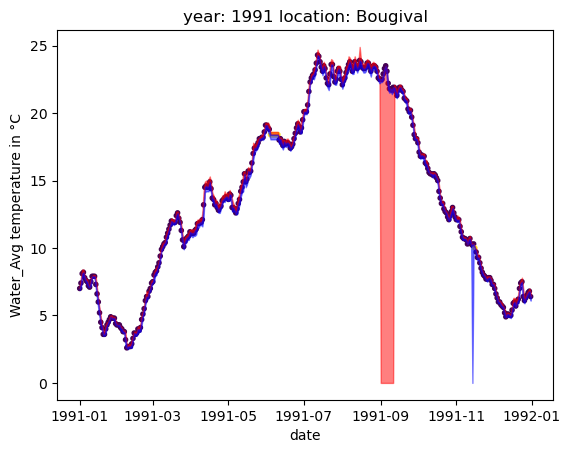

number of points:  365


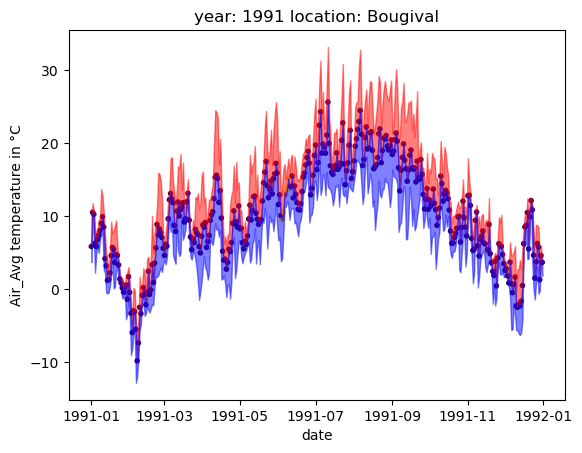

In [788]:
try: 
    year = next(year_iter)
    wiewer(year, location, main)
    wiewer_attribute(year, location, "Air_Avg", main)
except StopIteration: 
    location = next(location_iter)
    year_iter = get_iter(location, main)    

Remove the above year from data if something is not right.

In [693]:
years_to_discard = {"Bougival": [2016, 2020], "Choisy": [1999], "Orly_EDP": [2004, 2017]}

In [694]:
folder = "DataSets" 
main.to_csv(folder + "\WTA2_DataSet.csv", index=False)